This notebook is based on the UNETR Tutorial by MONAI (https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb)

##Setup Environment

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr  9 15:18:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!pip install -q "monai[all]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 KB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 KB 36.9 MB/s eta 0:00:0

##Imports

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric, HausdorffDistanceMetric, MeanIoU
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.1
gdown version: 4.6.6
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



##Data Directory

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpydo4xzrz


##Transfomations for Training and Testing 

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

##Download the Data based on Google Drive

In [ ]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/CSC413/Final Project/data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


##Check if Visualization is correct

image shape: torch.Size([1, 314, 214, 234]), label shape: torch.Size([1, 314, 214, 234])


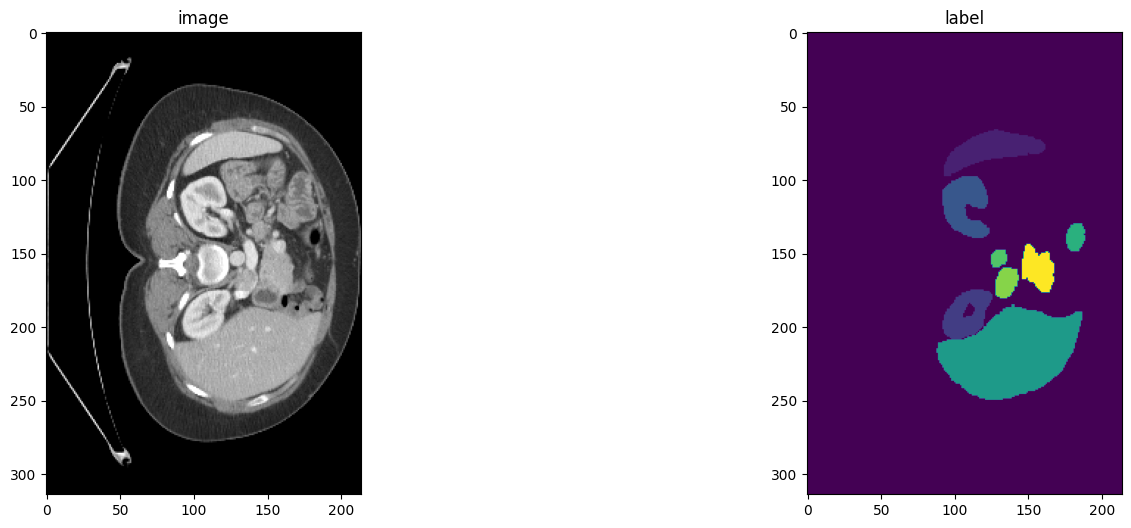

In [ ]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

##Model, Loss, Optimizer

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, jaccard=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            #hausdorff_distance(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        #mean_hausdorff = hausdorff_distance.aggregate().item()
        #hausdorff_distance.reset()
        dice_metric.reset()
    return mean_dice_val
    #return mean_hausdorff


#def train(global_step, train_loader, dice_val_best, global_step_best):
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            #hausdorff_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            #metric_values.append(hausdorff_val)
            if dice_val > dice_val_best:
            #if hausdorff_val > hausdorff_val_best:
                #hausdorff_val_best = hausdorff_val
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
                #print(
                    #"Model Was Saved ! Current Best Avg. Hausdorff: {} Current Avg. Hausdorff: {}".format(hausdorff_val_best, hausdorff_val)
                #)
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                #print(
                    #"Model Was Not Saved ! Current Best Avg. Hausdorff: {} Current Avg. Hausdorff: {}".format(
                        #hausdorff_val_best, hausdorff_val
                    #)
                #)
        global_step += 1
    return global_step, dice_val_best, global_step_best
    #return global_step, hausdorff_val_best, global_step_best


max_iterations = 10000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
hausdorff_distance = HausdorffDistanceMetric(include_background=True, reduction="mean", get_not_nans=False)
mean_iou = MeanIoU(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
hausdorff_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
    #global_step, hausdorff_val_best, global_step_best = train(global_step, train_loader, hausdorff_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 10000 Steps) (loss=2.21372):  88%|████████▊ | 21/24 [00:12<00:05,  1.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.08188432455062866 Current Avg. Dice: 0.08188432455062866


Training (1000 / 10000 Steps) (loss=1.85819):  71%|███████   | 17/24 [00:11<00:13,  1.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1111757680773735 Current Avg. Dice: 0.1111757680773735


Training (1500 / 10000 Steps) (loss=1.41009):  54%|█████▍    | 13/24 [00:11<00:21,  1.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12329413741827011 Current Avg. Dice: 0.12329413741827011


Training (2000 / 10000 Steps) (loss=1.49373):  38%|███▊      | 9/24 [00:10<00:31,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12400015443563461 Current Avg. Dice: 0.12400015443563461


Training (2500 / 10000 Steps) (loss=1.19886):  21%|██        | 5/24 [00:09<00:49,  2.59s/it]

Model Was Saved ! Current Best Avg. Dice: 0.14343255758285522 Current Avg. Dice: 0.14343255758285522


Training (3000 / 10000 Steps) (loss=1.74634):   4%|▍         | 1/24 [00:07<03:02,  7.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.14343255758285522 Current Avg. Dice: 0.13588640093803406


Training (3500 / 10000 Steps) (loss=1.36576):  88%|████████▊ | 21/24 [00:13<00:05,  1.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.14899076521396637 Current Avg. Dice: 0.14899076521396637


Training (4000 / 10000 Steps) (loss=1.30433):  71%|███████   | 17/24 [00:11<00:13,  1.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1988208293914795 Current Avg. Dice: 0.1988208293914795


Training (4500 / 10000 Steps) (loss=1.05568):  54%|█████▍    | 13/24 [00:10<00:19,  1.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.1988208293914795 Current Avg. Dice: 0.191833958029747


Training (5000 / 10000 Steps) (loss=1.06271):  38%|███▊      | 9/24 [00:10<00:30,  2.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.22345171868801117 Current Avg. Dice: 0.22345171868801117


Training (5500 / 10000 Steps) (loss=1.58377):  21%|██        | 5/24 [00:08<00:48,  2.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2519454061985016 Current Avg. Dice: 0.2519454061985016


Training (6000 / 10000 Steps) (loss=1.06706):   4%|▍         | 1/24 [00:08<03:16,  8.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.26120638847351074 Current Avg. Dice: 0.26120638847351074


Training (6500 / 10000 Steps) (loss=1.02067):  88%|████████▊ | 21/24 [00:12<00:05,  1.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2760103642940521 Current Avg. Dice: 0.2760103642940521


Training (7000 / 10000 Steps) (loss=1.06964):  71%|███████   | 17/24 [00:12<00:13,  1.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2871376872062683 Current Avg. Dice: 0.2871376872062683


Training (7500 / 10000 Steps) (loss=1.05954):  54%|█████▍    | 13/24 [00:11<00:22,  2.04s/it]

Model Was Saved ! Current Best Avg. Dice: 0.31049415469169617 Current Avg. Dice: 0.31049415469169617


Training (8000 / 10000 Steps) (loss=1.00877):  38%|███▊      | 9/24 [00:10<00:32,  2.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3737870752811432 Current Avg. Dice: 0.3737870752811432


Training (8500 / 10000 Steps) (loss=1.04139):  21%|██        | 5/24 [00:08<00:48,  2.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4080233871936798 Current Avg. Dice: 0.4080233871936798


Training (9000 / 10000 Steps) (loss=0.93505):   4%|▍         | 1/24 [00:08<03:11,  8.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48191067576408386 Current Avg. Dice: 0.48191067576408386


Training (9500 / 10000 Steps) (loss=1.14280):  88%|████████▊ | 21/24 [00:13<00:05,  1.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49344301223754883 Current Avg. Dice: 0.49344301223754883


Training (10000 / 10000 Steps) (loss=0.99654):  71%|███████   | 17/24 [00:12<00:13,  1.95s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5022909641265869 Current Avg. Dice: 0.5022909641265869


Training (10007 / 10000 Steps) (loss=0.88267): 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


<All keys matched successfully>

In [ ]:
#print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.0000 at iteration: 10000


##Plot and Print the Loss and Metric

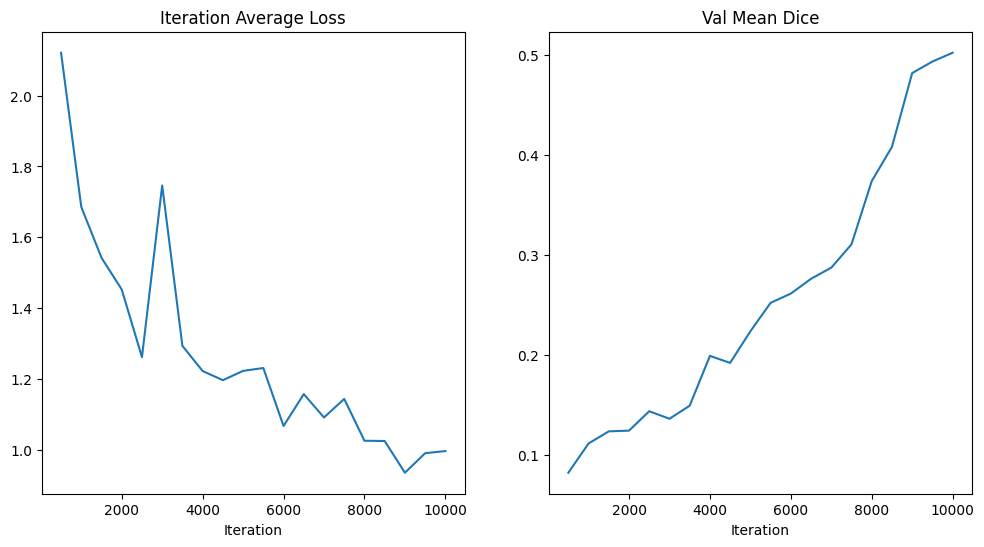

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Jaccard")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#DiceCELoss + Jaccard Index
print(epoch_loss_values)
print(metric_values)

[2.121090673265003, 1.6855009934481453, 1.5420340666404138, 1.4523573716481526, 1.261518406867981, 1.7463443279266357, 1.2931859720320928, 1.2222113749560188, 1.1963955530753503, 1.2226560910542805, 1.2307371616363525, 1.0670576095581055, 1.1570426112129575, 1.0910405972424675, 1.1435076548502996, 1.0253233247333102, 1.0245968341827392, 0.9350525736808777, 0.9901610953467233, 0.9961843736031476]
[0.08188432455062866, 0.1111757680773735, 0.12329413741827011, 0.12400015443563461, 0.14343255758285522, 0.13588640093803406, 0.14899076521396637, 0.1988208293914795, 0.191833958029747, 0.22345171868801117, 0.2519454061985016, 0.26120638847351074, 0.2760103642940521, 0.2871376872062683, 0.31049415469169617, 0.3737870752811432, 0.4080233871936798, 0.48191067576408386, 0.49344301223754883, 0.5022909641265869]


##Check the best model output

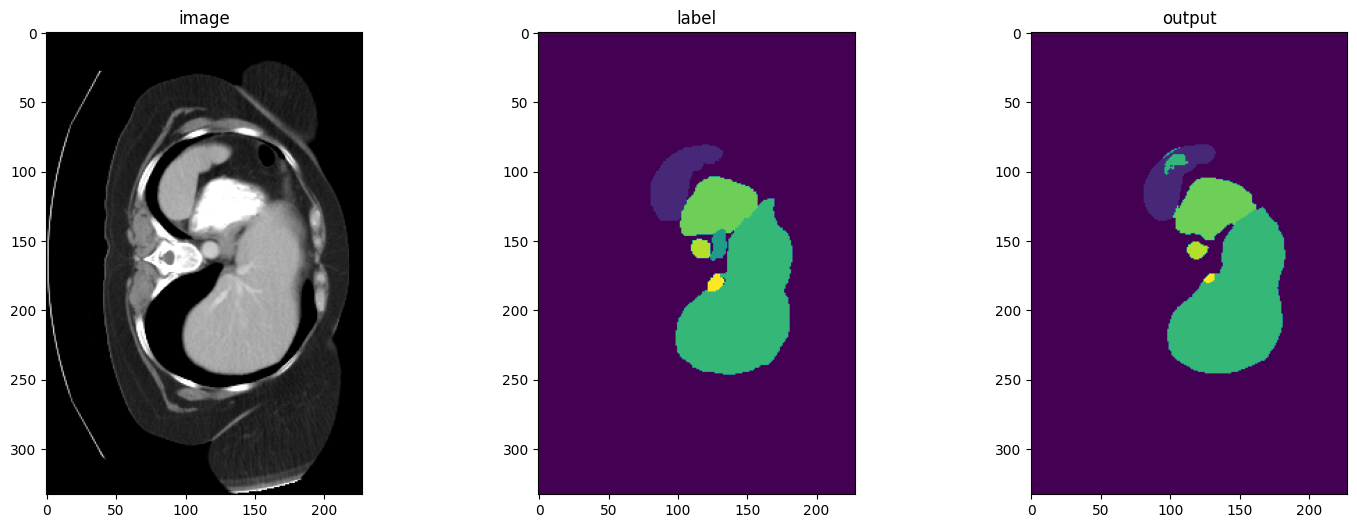

In [ ]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)